# Assigment 4: Transformers

In this assignment, you will be implementing a simplified Transformer from scratch, and training it to count letters used in the sequence.

You are expressively not-allowed to use any off-the-shelf implementations of attention mechanisms, such as `nn.TransformerEncoder`, `nn.TransformerDecoder`, etc. 

The assignment can be completed using only the functions we have imported and Tensor manipulations (`squeeze`, `unsqueeze`, `view`, `split`, `chunk`, `concat`). 

If you desire to use others, feel free to ask on Piazza or at Office Hours.

![trn.svg](trn.svg)

## 1) Multi-head Attention

In this section, you will be implementing an Encoder transformer block with no LayerNorm that logs the attention maps. 

Tips:
- We reccomend you start with a single head, and make sure to check the dimensions of your Tensors with `.shape` after each calculation. 
- Make sure to store a deep copy of your residuals, rather than references.
- The attention map(s) are the $softmax(\frac{Q K^T}{\sqrt{d_k}})$ term(s).
    - We recomend you cache this as a layer-property rather than include it during inference, as the latter strategies complicates transformers with more than one layer.
 
![f.svg](f.svg)

In [ ]:
%pip install torch
%pip install matplotlib
%pip install scikit-learn
%pip install tqdm
%pip install numpy

In [ ]:
from torch.nn import Module, Linear, ReLU
from torch.nn.functional import softmax
from torch import matmul, zeros, concat, cat
from math import sqrt

class TransformerLayer(Module):
    def __init__(self, d_model, d_internal, d_ff, n_heads, max_seq_len=20):
        """
        :param d_model: The dimension of the inputs and outputs of the layer 
            (note that the inputs and outputs have to be the same size for the residual connection to work)
        :param d_internal: The "internal" dimension used in the self-attention computation. 
            Your keys and queries should both be of this length per head.
        :param d_ff: The "feed forward" dimension used in the feed-foward computation. 
            You should have a linear transformation from d_model to d_ff, and then following an activation, d_ff to d_model.
        :param n_heads: The number of attention heads used. 
            Keep this number low for efficiency.
        :param max_seq_len: The max sequence length. 
        """
        super().__init__()

        self.d_model = d_model
        self.d_internal = d_internal
        self.n_heads = n_heads
        self.max_seq_len = max_seq_len
        self.last_map = zeros(n_heads,max_seq_len,max_seq_len)

        # TODO 1.1) Define the QKV linear transformations
        self.q_proj = ...
        self.k_proj = ...
        self.v_proj = ...

        # TODO 1.2) Define the multi-head attention linear transformations
        self.mha_proj = ...
                
        # TODO 1.3) Define the feedforward 
        self.ff1 = ...
        self.activation = ...
        self.ff2 = ....

    
    def forward(self, input_vecs):
        """
        :param input_vecs: an input tensor of shape [seq len, d_model]
        :return: a tensor of shape [seq len, d_model] representing the log probabilities of each position in the input     
        """

        q,k,v = input_vecs,input_vecs,input_vecs

        # TODO 1.5) Calculate MHA up to the attention map

        # TODO 1.6) Cache latest attention map 

        # TODO 1.7) Complete MHA

        # TODO 1.8) Add residual

        # TODO 1.9) Apply feed forward and add second residual

        return x

#### Deliverable - Test Cases

In [ ]:
import random
from torch import manual_seed,randn
from numpy import round as npround

random.seed(42)
manual_seed(42)

# Single-head test case
input_tensor = randn(5,8)

sh_attn = TransformerLayer(d_model=8,d_internal=32,d_ff=64, n_heads=1,max_seq_len=5)
print('Single-head output')
print(npround(sh_attn(input_tensor).detach().numpy(),4),'\n')
print('Single-head attention map')
print(npround(sh_attn.last_map.detach().numpy(),4),'\n')

print('='*60,'\n')

# Mutlti-head test case
sh_attn = TransformerLayer(d_model=8,d_internal=16,d_ff=128, n_heads=2,max_seq_len=5)

print('Multi-head output')
print(npround(sh_attn(input_tensor).detach().numpy(),4),'\n')
print('Multi-head attention maps')
print(npround(sh_attn.last_map.detach().numpy(),4))

## 2) Embeddings and Positional Encoding

Next we will be creating the Transformer model base.

Below you will need to implement the embeddings, as well as a forward function.

Each token's embedding should be the sum of two embeddings; 
1. the word embedding that embeds the vocabulary in a `d_model`-dim space.
2. the absolute positional encoding that embeds each index in a `d_model`-dim space. Since all the inputs in this assignment will be of length `max_seq_len`, you can consider it a mapping from the `max_seq_len`-dim indices to `d_model`, and embed each index using a range.

Lastly the forward should:
1. Apply the embeddings
2. Apply the `nn.Sequential` of the Encoder layers
    - And after this, iterate through the `nn.Sequential to retrieve the cached maps for each layer
3. Apply the simplified decoder layer
4. Convert the outputs to log probabilities over the tokens, and return them along with the maps

![pos.svg](pos.svg)


<html></html>


In [ ]:
from torch import tensor, LongTensor, FloatTensor, log, concat, cat
from torch.nn import Sequential, Embedding
from torch.nn.functional import log_softmax

class Transformer(Module):
    def __init__(self, vocab_size, max_seq_len, d_model, d_internal, num_classes, d_ff, num_layers, num_heads):
        """
        :param vocab_size: vocabulary size of the embedding layer
        :param max_seq_len: max sequence length that will be fed to the model; should be 20
        :param d_model: see TransformerLayer
        :param d_internal: see TransformerLayer
        :param d_ff: see TransformerLayer
        :param num_classes: number of classes predicted at the output layer; should be 3
        :param num_layers: number of TransformerLayers to use; can be whatever you want
        :param num_layers: number of heads per TransformerLayer; can be whatever you want
        """
        super().__init__()
        self.max_seq_len = max_seq_len
        
        layers = []
        for i in range(num_layers):
            layer = TransformerLayer(d_model=d_model, d_internal=d_internal,n_heads=num_heads,d_ff=d_ff,max_seq_len=max_seq_len)
            layers.append(layer)
        self.encoders = Sequential(*layers)
        self.decoder = Linear(d_model, num_classes)

        # TODO 2.1) Define word embedding

        # TODO 2.2) Define positional encoding


    def forward(self, indices):
        """
        :param indices: list of input indices
        :return: A tuple of the softmax log probabilities (should be a 20x3 matrix) and a list of the attention
        maps you use in your layers (can be variable length, but each should be a 20x20 matrix)
        """
        # TODO 2.3) Apply word embedding and positional encoding

        # TODO 2.4) Layer Forward Passes
        
        # TODO 2.5) Return the log-probabilites and cached maps for every layer and head
        return (x, maps)

#### Deliverable - Embedding

Provide the embedding (word embedding plus positional encoding) for [1,1,2,2,3], 
using d_model=16, max_seq_len=5.

## 3) Dataset Processing

The dataset for this transformer implementation will be letter-counting. 

Given a string, your model should predict how many times that character has occurred previously.
To simplify the computation, this will be split into bins of n=0, n=1, and n>=2

Specifically for we be considering two settings:

1) Task 1 - counts of the letter *before* the current index
2) Task 2 - counts of the letter *before* and *after* the current index

We provide helper functions for formatting the tasks, your job is to write a function `indexer` that takes the 20 character strings and converts them to `LongTensor`s of IDs. 


Read from `lettercounting-train.txt`, `letttercounting-dev.txt`.
For both the train and eval set, collect an array for the strings, the ID tensors, and the gold standard outputs for both tasks.

In [ ]:
import numpy as np
from torch import LongTensor

def task1(input: str) -> LongTensor:
    output = np.zeros(len(input))
    for i in range(0, len(input)):
        output[i] = min(2, len([c for c in input[0:i] if c == input[i]]))
    return LongTensor(output)

def task2(input: str) -> LongTensor:
    output = np.zeros(len(input))
    for i in range(0, len(input)):
        output[i] = min(2, len([c for c in input if c == input[i]]) - 1)
    return LongTensor(output)

def indexer(input: str) -> LongTensor:
    # TODO 3.1) map string to character index LongTensor.
    # Note that all the characters are either spaces or the lowercase alphabet
    return LongTensor(...)    


with open('lettercounting-train.txt','r',encoding='utf8') as train_file:
    # TODO 3.2) Process train_file
    pass
    
with open('lettercounting-dev.txt','r',encoding='utf8') as eval_file:
    # TODO 3.3) Process eval_file
    pass

#### Deliverable: Provide the ID tensor and task tensors for the string "ed by rank and file".


## 4) Training Loop

Now that we have both our model and our dataset, it is time to train and evaluate on our tasks.

The following code blocks provide a helper function for visualizing your attention maps (so you can see it learning), as well as loss functions / optimizers / learning rate schedulers that may come in handy.

To complete this section, you must provide us with models that achieve >90% eval accuracy on each task.
If implemented properly, this can be done with 1 layer and 1 head/layer, however, we encourage you to experiment.



In your solution, provide us with the following:
- train losses logged at ~100-250 steps
- eval losses logged every ~5-10 train loss updates
- for each eval update, the accuracy and macro-F1 scores of the train/eval.
    - this is best done accumulating arrays of the predictions and model outputs throughout the training loop, and then calls the to the scikit-learn metrics.

You can return these in any form you would like (table, graph, etc), as long as they are immediately interpretable (for example, normalizing the train/eval loss for number of examples would be necessary).


Additionally, describe any issues you had with selecting on optimal learning rate, loss function, etc.

ANSWER HERE

In [ ]:
#Note, if you are unable to store the outputs from plt.show(), configure the plot_maps function to use savefig()

import matplotlib.pyplot as plt

def plot_maps(maps,text):
    maps = maps.detach().numpy()
    num_layers = maps.shape[0]
    num_heads = maps.shape[1]
    fig, axs = plt.subplots(num_heads,num_layers,figsize=(num_layers*4,num_heads*4))

    for head_index in range(num_heads):
        for layer_index in range(num_layers):
            if num_heads==1 and num_layers == 1:
                ax = axs
            elif num_layers==1:
                ax = axs[head_index]
            elif num_heads==1:
                ax = axs[layer_index]
            else:
                ax = axs[head_index][layer_index]
            attn_map = maps[layer_index][head_index]
            ax.imshow(attn_map, cmap='hot', interpolation='nearest')
            ax.set_xticks(np.arange(len(text)), labels=text)
            ax.set_yticks(np.arange(len(text)), labels=text)
            ax.xaxis.tick_top()
            
    # if not using juypter notebook 
    #plt.savefig("maps.png")
    # otherwise
    plt.show()

In [ ]:
# Loss functions
from torch.nn import NLLLoss,BCELoss,CrossEntropyLoss
# Optimizers
from torch.optim import SGD, Adam, AdamW, Adadelta 
# Learning rate schedulers (optional)
from torch.optim.lr_scheduler import LinearLR, StepLR, CosineAnnealingLR

from torch import no_grad
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
import random
random.seed(0)

model = ...
optimizer = ...
num_epochs = ...

for ep in range(num_epochs):
    model.train()
    # Train loop
    # Log losses, predictions/gold standards for accuracy/F1

    model.eval()
    with no_grad():
        # Eval loop
            # Log losses, predictions/gold standards for accuracy/F1

#### Deliverable: the chart or graph of the training/eval for both models. Make sure to label the losses/acc/f1 as train/eval, and normalize the losses by the number of data points they are derived from.

## 5) Visualization
Lastly we will examine the computation performed by the model(s) you've trained using its attention maps.

The following are 1-layer, 1-head models trained on Task 1 (the before task), and Task 2 (the before/after task) respectively. They both achieve accuracy ~95%.
<div class="row">
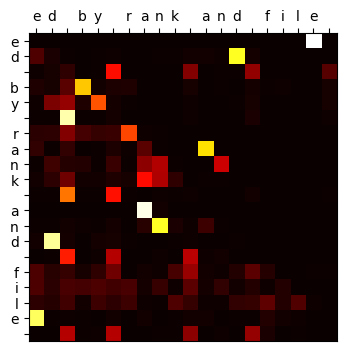
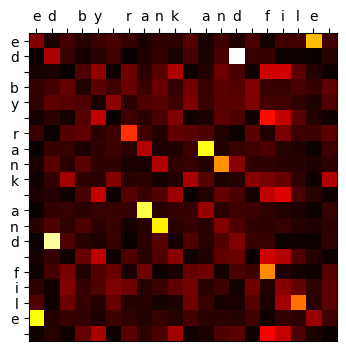

>

#### Deliverable 5.1) Hypothesize on how these attention maps reflect the computation done by their associated models. Specifically address how each handles the tokens ['e', 'a', 'n', 'd', ' '], how they are similar, and how/why they may be different.

ANSWER HERE

#### Deliverable 5.2) Train a multi-layer (>4), single-head model on one of the tasks. 
Achieve an eval accuracy of at least 80%, and plot the attention maps below on the string `"ed by rank and file"`.

Hypothesize on how each layer contributes to the classification.

ANSWER HERE

#### Deliverable 5.3) Train a multi-head model on one of the tasks.
Achieve an eval accuracy of at least 80%, and plot the attention maps below on the string `"ed by rank and file"`.

Hypothesize on how each head contributes to the classification.

ANSWER HERE

#### Acknowledgement

This homework was adapted from CS388, taught by Greg Durrett at University of Texas Austin, and CS685, taught by Mohit Iyyer, then at University of Massachusetts Amherst.

The visualizations take inspiration from a twitter post by Mark Riedl of Georgia Tech. 